In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ctgan import CTGAN
from ctgan import load_demo
import data_describe as dd
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data = pd.read_csv('../data/S&P 500 Energy 200-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data

,date,S&P 500,S&P 500 Energy (Sector),S&P 500 Performance (%),S&P 500 Energy (Sector) Performance (%),S&P 500 Energy (Sector) Outperform/Underperform,overall,energy,energy commodities,fuels and utilities,transportation,transportation services,utilities and public transportation
0,1993-01-04,435.38,90.74,-7.059451,-15.069262,UNDERPERFORM,143.100,104.300,100.500,118.900,160.800,160.800,131.800
1,1993-01-05,434.34,90.91,-6.835975,-14.582355,UNDERPERFORM,143.100,104.300,100.500,118.900,160.800,160.800,131.800
2,1993-01-06,434.52,90.89,-6.769369,-14.246627,UNDERPERFORM,143.100,104.300,100.500,118.900,160.800,160.800,131.800
3,1993-01-07,430.73,89.91,-7.441551,-14.591052,UNDERPERFORM,143.100,104.300,100.500,118.900,160.800,160.800,131.800
4,1993-01-08,429.05,88.90,-7.386621,-15.276851,UNDERPERFORM,143.100,104.300,100.500,118.900,160.800,160.800,131.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7280,2021-11-24,4701.46,436.37,19.144655,-30.218761,UNDERPERFORM,280.126,263.553,309.682,272.154,326.397,326.397,233.199
7281,2021-11-26,4594.62,418.74,17.770003,-31.294403,UNDERPERFORM,280.126,263.553,309.682,272.154,326.397,326.397,233.199
7282,2021-11-29,4655.27,421.22,20.187797,-29.357506,UNDERPERFORM,280.126,263.553,309.682,272.154,326.397,326.397,233.199
7283,2021-11-30,4567.00,410.70,17.105867,-31.174903,UNDERPERFORM,280.126,263.553,309.682,272.154,326.397,326.397,233.199


## Using data after 2010 (Best Model)

In [3]:
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2010]
data

,year,month,date,S&P 500,S&P 500 Energy (Sector),S&P 500 Performance (%),S&P 500 Energy (Sector) Performance (%),S&P 500 Energy (Sector) Outperform/Underperform,overall,energy,energy commodities,fuels and utilities,transportation,transportation services,utilities and public transportation,dow
204,2010,1,2010-01-14,1148.46,448.26,-2.941027,1.281095,OUTPERFORM,217.281,209.624,239.914,212.638,257.050,257.050,201.045,3
205,2010,2,2010-02-11,1078.47,417.06,-9.326551,-10.155106,UNDERPERFORM,217.353,209.326,237.315,214.506,257.804,257.804,202.330,3
206,2010,3,2010-03-11,1150.24,434.70,-8.476491,-13.402924,UNDERPERFORM,217.403,209.219,237.093,214.821,258.306,258.306,202.917,3
207,2010,4,2010-04-08,1186.44,442.81,-7.551331,-15.531351,UNDERPERFORM,217.290,206.631,232.440,214.303,258.969,258.969,203.124,3
208,2010,5,2010-05-13,1157.44,429.09,-12.792152,-26.104328,UNDERPERFORM,217.199,203.764,227.477,213.427,259.454,259.454,203.501,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,2021,7,2021-07-08,4320.82,391.55,1.147999,-32.479738,UNDERPERFORM,273.092,242.958,276.734,262.483,326.470,326.470,229.005,3
343,2021,8,2021-08-12,4460.83,375.97,7.276877,-43.803716,UNDERPERFORM,274.214,245.847,280.047,265.333,323.329,323.329,229.123,3
344,2021,9,2021-09-09,4493.28,357.55,15.209058,-36.406161,UNDERPERFORM,276.590,255.010,293.342,270.870,323.995,323.995,231.525,3
345,2021,10,2021-10-14,4438.26,432.43,8.483351,-26.012045,UNDERPERFORM,278.524,261.257,305.653,271.467,326.256,326.256,232.450,3


In [4]:
original = data[['S&P 500 Energy (Sector) Outperform/Underperform','month','overall','energy',\
                 'energy commodities','fuels and utilities','transportation','transportation services','utilities and public transportation']]

In [5]:
data.drop(columns=['date','S&P 500 Energy (Sector) Outperform/Underperform','year'], inplace=True)
data.head()

,month,S&P 500,S&P 500 Energy (Sector),S&P 500 Performance (%),S&P 500 Energy (Sector) Performance (%),overall,energy,energy commodities,fuels and utilities,transportation,transportation services,utilities and public transportation,dow
204,1,1148.46,448.26,-2.941027,1.281095,217.281,209.624,239.914,212.638,257.050,257.050,201.045,3
205,2,1078.47,417.06,-9.326551,-10.155106,217.353,209.326,237.315,214.506,257.804,257.804,202.330,3
206,3,1150.24,434.70,-8.476491,-13.402924,217.403,209.219,237.093,214.821,258.306,258.306,202.917,3
207,4,1186.44,442.81,-7.551331,-15.531351,217.290,206.631,232.440,214.303,258.969,258.969,203.124,3
208,5,1157.44,429.09,-12.792152,-26.104328,217.199,203.764,227.477,213.427,259.454,259.454,203.501,3


In [6]:
original['Performance'] = np.where(original['S&P 500 Energy (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','energy','energy commodities','fuels and utilities',\
                     'transportation','transportation services','utilities and public transportation']]

In [7]:
dd.data_summary(original)

,Info
Rows,143
Columns,9
Size in Memory,11.2 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,1,1,0.68,0.47,2,97
month,int64,0,0,1,6,12,6.46,3.43,12,12
overall,float64,0,0,217.20,238.033,280.13,241.91,14.66,141,2
energy,float64,0,0,176.40,218.54,263.55,221.44,21.49,143,1
energy commodities,float64,0,0,164.91,244.44,336.42,253.77,45.069,143,1
fuels and utilities,float64,0,0,212.64,233.35,272.15,233.33,12.69,143,1
transportation,float64,0,0,257.050,295.59,333.37,296.10,22.11,143,1
transportation services,float64,0,0,257.050,295.59,333.37,296.10,22.11,143,1
utilities and public transportation,float64,0,0,201.045,215.62,233.20,214.57,6.39,143,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

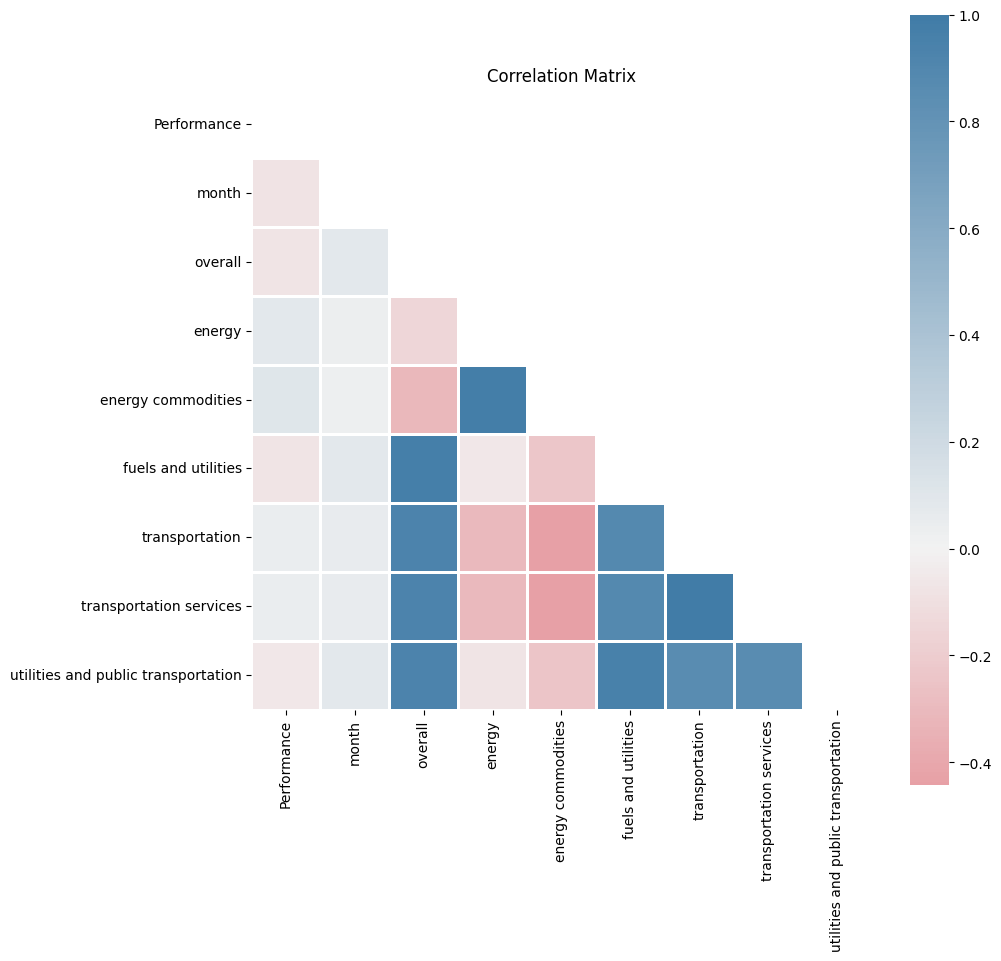

In [8]:
dd.correlation_matrix(original)

### Conditional GAN

In [9]:
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Energy (Sector),S&P 500 Performance (%),S&P 500 Energy (Sector) Performance (%),overall,energy,energy commodities,fuels and utilities,transportation,transportation services,utilities and public transportation,dow
0,7,2396.328339,542.744741,0.068621,18.003389,237.500838,216.293516,245.170506,241.600214,309.572320,315.638867,218.751747,3
1,11,3714.647956,167.044532,0.364078,-46.790136,273.007899,234.000741,274.410220,280.132967,322.094668,315.714741,226.895206,3
2,2,4255.610711,522.660333,-7.538993,-18.043216,270.824192,236.764035,300.715228,269.055973,333.079915,331.331642,218.245682,3
3,5,1804.910767,389.386534,-9.113658,-37.405226,240.775550,208.928367,223.451088,221.693234,277.605416,293.371534,213.578486,3
4,12,3701.904335,202.141840,-16.527170,-41.842833,260.178639,198.750729,225.936800,273.463330,308.610365,316.313164,226.047492,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,8,2528.584277,588.100934,-18.058515,-18.980646,276.212585,233.513612,285.983707,240.498373,317.236136,314.031788,224.375153,3
9996,3,2608.631295,460.007805,-15.613001,-2.862841,245.079483,202.851650,228.944015,242.437627,307.673817,314.231777,215.911589,3
9997,7,2456.669595,425.595086,0.135343,-24.800038,254.283094,221.386952,260.182336,255.945968,318.312488,321.140215,217.931602,3
9998,1,1286.550090,437.829805,5.205561,10.984803,227.754141,202.401425,252.012024,220.895656,284.957028,290.275344,215.952222,3


In [10]:
samples['Performance'] = np.where(samples['S&P 500 Energy (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)

In [11]:
samples = samples[['Performance','month', 'overall','energy','energy commodities','fuels and utilities',\
                   'transportation','transportation services','utilities and public transportation']]
samples.head()

,Performance,month,overall,energy,energy commodities,fuels and utilities,transportation,transportation services,utilities and public transportation
0,1,7,237.500838,216.293516,245.170506,241.600214,309.572320,315.638867,218.751747
1,0,11,273.007899,234.000741,274.410220,280.132967,322.094668,315.714741,226.895206
2,0,2,270.824192,236.764035,300.715228,269.055973,333.079915,331.331642,218.245682
3,0,5,240.775550,208.928367,223.451088,221.693234,277.605416,293.371534,213.578486
4,0,12,260.178639,198.750729,225.936800,273.463330,308.610365,316.313164,226.047492


In [12]:
dd.data_summary(samples)

,Info
Rows,10000
Columns,9
Size in Memory,703.2 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,1,1,0.71,0.45,2,7122
month,int64,0,0,1,6,12,6.46,3.44,12,885
overall,float64,0,0,204.84,240.45,290.53,243.10,15.56,9999,2
energy,float64,0,0,178.18,218.83,267.78,223.18,19.61,10000,1
energy commodities,float64,0,0,172.82,255.11,353.93,264.48,39.29,10000,1
fuels and utilities,float64,0,0,208.58,235.090,290.32,236.83,14.95,10000,1
transportation,float64,0,0,243.096,297.33,343.068,298.011,22.075,10000,1
transportation services,float64,0,0,237.46,294.68,343.11,297.20,21.24,9998,2
utilities and public transportation,float64,0,0,198.00,216.76,240.79,215.97,7.24,9999,2


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

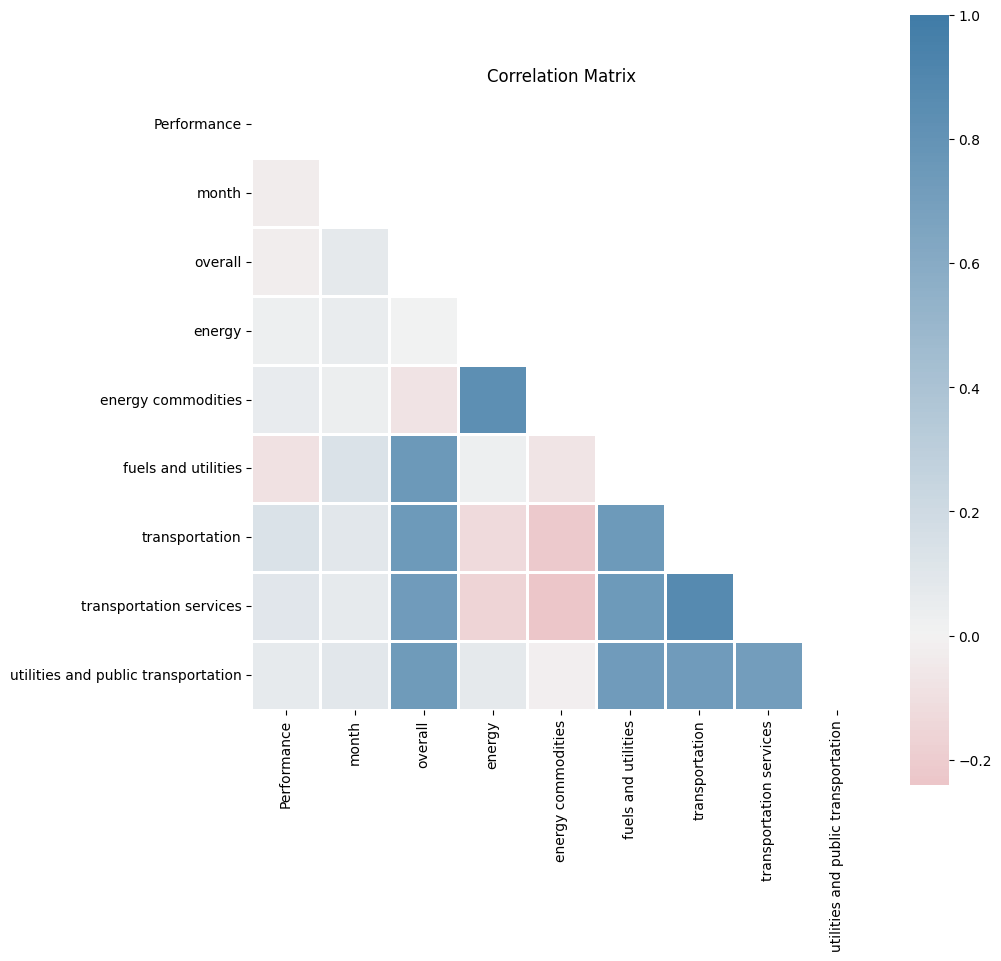

In [13]:
dd.correlation_matrix(samples)

In [14]:
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']

### SMOTE Oversampling

In [15]:
counter = Counter(y)
print(counter)
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({1: 7122, 0: 2878})
Counter({1: 7122, 0: 7122})


### Interaction Terms

In [16]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
X_poly

array([[   237.50083801,    216.29351608,    245.17050607, ...,
         97713.05629951,  67719.48589163,  69046.55348815],
       [   273.00789887,    234.00074074,    274.41022039, ...,
        101690.03464863,  73081.73623592,  71634.16122475],
       [   270.82419205,    236.76403488,    300.71522812, ...,
        110359.91488466,  72693.25318064,  72311.70013046],
       ...,
       [   290.17648935,    237.69890543,    289.21979111, ...,
        104408.6072439 ,  74306.87434076,  72995.53616968],
       [   261.21424642,    237.85384761,    287.50250724, ...,
         80824.68781019,  61689.19919335,  61061.89672397],
       [   230.42946331,    203.98194439,    232.38074333, ...,
         77564.12232876,  56813.49490602,  56506.60802702]])

In [17]:
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X.shape

(14244, 29)

In [18]:
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
X_real.shape

(143, 29)

In [19]:
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)

### Training with CV

In [20]:
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.829411,0.886582,0.756675,0.816252,0.812693,0.87251,0.734489,0.797572,0.72028,0.87013,0.690722,0.770115
1,DecisionTreeClassifier,0.804908,0.824991,0.776187,0.799414,0.784892,0.794135,0.77194,0.78288,0.671329,0.804878,0.680412,0.73743
2,RandomForestClassifier,0.876026,0.891177,0.858048,0.874031,0.858186,0.871098,0.84237,0.856493,0.783217,0.858696,0.814433,0.835979
3,AdaBoostClassifier,0.786158,0.767154,0.821962,0.793486,0.771693,0.754697,0.808273,0.780567,0.797203,0.84,0.865979,0.852792
4,GradientBoostingClassifier,0.812698,0.796971,0.839656,0.817623,0.806234,0.792132,0.832868,0.811989,0.832168,0.892473,0.85567,0.873684
5,ExtraTreesClassifier,0.89786,0.917868,0.875319,0.895824,0.877001,0.895723,0.854667,0.874714,0.804196,0.863158,0.845361,0.854167
6,BaggingClassifier,0.849489,0.882591,0.807641,0.843175,0.839371,0.872627,0.796534,0.832846,0.769231,0.880952,0.762887,0.81768
7,SVC,0.78974,0.776339,0.814102,0.79463,0.783488,0.774542,0.802683,0.788361,0.804196,0.863158,0.845361,0.854167
8,GaussianNB,0.754074,0.731867,0.801888,0.765179,0.750913,0.735632,0.787032,0.760464,0.741259,0.806122,0.814433,0.810256


### Voting Classifier

In [21]:
et_clf = ExtraTreesClassifier(random_state=random_state)
bag_clf = BaggingClassifier(random_state=random_state)
rf_clf = RandomForestClassifier(random_state=random_state)
classifiers = [('RF', rf_clf), \
               ('ET', et_clf),\
              ('Bagging', bag_clf)]

vc = VotingClassifier(estimators = classifiers, voting = 'soft')     
vc.fit(x_train, y_train)
y_pred = vc.predict(x_test)
vc_res = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F-1 Score'])
vc_res.loc[0, 'Accuracy'] = accuracy_score(y_test, y_pred)
vc_res.loc[0, 'Precision'] = precision_score(y_test, y_pred)
vc_res.loc[0, 'Recall'] = recall_score(y_test, y_pred)
vc_res.loc[0, 'F-1 Score'] = f1_score(y_test, y_pred)
vc_res

,Accuracy,Precision,Recall,F-1 Score
0,0.867172,0.879032,0.85299,0.865816


## Using data after 2000

In [22]:
data = pd.read_csv('../data/S&P 500 Energy 200-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2000]
data

,year,month,date,S&P 500,S&P 500 Energy (Sector),S&P 500 Performance (%),S&P 500 Energy (Sector) Performance (%),S&P 500 Energy (Sector) Outperform/Underperform,overall,energy,energy commodities,fuels and utilities,transportation,transportation services,utilities and public transportation,dow
84,2000,1,2000-01-13,1449.68,219.62,5.081257,-4.707771,UNDERPERFORM,170.000,118.800,122.400,134.500,193.600,193.600,149.400,3
85,2000,2,2000-02-10,1416.83,196.08,5.594103,-19.431319,UNDERPERFORM,171.000,124.300,133.400,133.600,194.400,194.400,149.800,3
86,2000,3,2000-03-09,1401.69,212.05,9.948543,-8.016310,UNDERPERFORM,170.900,120.900,126.100,133.700,194.700,194.700,150.000,3
87,2000,4,2000-04-13,1440.51,215.82,4.861217,-5.977172,UNDERPERFORM,171.200,120.000,124.100,133.800,195.500,195.500,150.300,3
88,2000,5,2000-05-11,1407.81,230.91,11.913923,-0.409730,UNDERPERFORM,172.200,126.800,134.900,136.600,196.000,196.000,151.500,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,2021,7,2021-07-08,4320.82,391.55,1.147999,-32.479738,UNDERPERFORM,273.092,242.958,276.734,262.483,326.470,326.470,229.005,3
343,2021,8,2021-08-12,4460.83,375.97,7.276877,-43.803716,UNDERPERFORM,274.214,245.847,280.047,265.333,323.329,323.329,229.123,3
344,2021,9,2021-09-09,4493.28,357.55,15.209058,-36.406161,UNDERPERFORM,276.590,255.010,293.342,270.870,323.995,323.995,231.525,3
345,2021,10,2021-10-14,4438.26,432.43,8.483351,-26.012045,UNDERPERFORM,278.524,261.257,305.653,271.467,326.256,326.256,232.450,3


In [23]:
original = data[['S&P 500 Energy (Sector) Outperform/Underperform','month','overall','energy',\
                 'energy commodities','fuels and utilities','transportation','transportation services','utilities and public transportation']]
data.drop(columns=['date','S&P 500 Energy (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Energy (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','energy','energy commodities','fuels and utilities',\
                     'transportation','transportation services','utilities and public transportation']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Energy (Sector),S&P 500 Performance (%),S&P 500 Energy (Sector) Performance (%),overall,energy,energy commodities,fuels and utilities,transportation,transportation services,utilities and public transportation,dow
0,11,877.066189,211.891323,-15.005862,-22.047218,176.664915,140.031093,148.857946,157.988049,215.378228,220.925967,163.372075,3
1,8,1390.694886,247.865643,2.356592,-9.445645,178.453435,154.144664,196.090145,156.360585,213.445692,221.973396,164.886998,3
2,5,1411.576853,462.543535,9.915288,31.865767,212.508743,201.009482,148.212925,214.701057,213.476536,259.910819,163.420537,3
3,5,1066.647888,469.007446,-8.774128,17.447038,229.732158,137.020541,169.370167,157.579629,213.548003,230.643729,162.628706,3
4,2,4301.886704,479.606557,-13.841048,-32.198661,273.979064,207.760450,253.127175,252.047318,295.524411,329.929323,224.756967,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9,2574.502820,477.307594,-9.257991,-5.903477,224.870297,193.341014,214.825158,212.911692,224.411527,278.129294,206.943641,3
9996,12,3705.058536,570.175352,-11.986520,-28.955679,259.293400,211.549476,248.544863,265.969183,332.889152,323.568569,228.981469,3
9997,9,1440.340834,566.890228,-2.188174,92.741115,203.367546,206.222238,241.895269,219.600009,223.493134,230.215772,215.573678,3
9998,4,4299.905013,434.479659,8.044247,-36.115059,253.733500,207.565167,240.096590,249.636955,327.259495,313.451703,225.537239,3


In [24]:
samples['Performance'] = np.where(samples['S&P 500 Energy (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month', 'overall','energy','energy commodities','fuels and utilities',\
                   'transportation','transportation services','utilities and public transportation']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.60987,0.605747,0.626568,0.615676,0.629989,0.640028,0.652017,0.645967,0.676806,0.685315,0.710145,0.697509
1,DecisionTreeClassifier,0.594945,0.591149,0.60735,0.59818,0.57404,0.584945,0.610231,0.59732,0.539924,0.560284,0.572464,0.566308
2,RandomForestClassifier,0.665644,0.658564,0.684764,0.669862,0.658709,0.668808,0.675072,0.671925,0.707224,0.729323,0.702899,0.715867
3,AdaBoostClassifier,0.636728,0.627884,0.671141,0.648657,0.647893,0.654596,0.677233,0.665722,0.631179,0.651852,0.637681,0.644689
4,GradientBoostingClassifier,0.648852,0.638921,0.684387,0.660782,0.656098,0.662483,0.684438,0.673281,0.726236,0.746269,0.724638,0.735294
5,ExtraTreesClassifier,0.665553,0.661055,0.673951,0.665426,0.669153,0.679828,0.682277,0.68105,0.692015,0.72093,0.673913,0.696629
6,BaggingClassifier,0.636731,0.648797,0.592432,0.618327,0.621783,0.65429,0.571326,0.61,0.60076,0.651376,0.514493,0.574899
7,SVC,0.628893,0.616334,0.68252,0.647637,0.635957,0.63715,0.689481,0.662284,0.726236,0.72,0.782609,0.75
8,GaussianNB,0.59112,0.572196,0.721129,0.638015,0.604625,0.596019,0.733429,0.657623,0.684411,0.670807,0.782609,0.722408


## Using all data

In [25]:
data = pd.read_csv('../data/S&P 500 Energy 200-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data

,year,month,date,S&P 500,S&P 500 Energy (Sector),S&P 500 Performance (%),S&P 500 Energy (Sector) Performance (%),S&P 500 Energy (Sector) Outperform/Underperform,overall,energy,energy commodities,fuels and utilities,transportation,transportation services,utilities and public transportation,dow
0,1993,1,1993-01-14,435.94,89.26,-6.796656,-15.879747,UNDERPERFORM,143.100,104.300,100.500,118.900,160.800,160.800,131.800,3
1,1993,2,1993-02-11,447.66,95.06,-3.325703,-4.037957,UNDERPERFORM,143.300,104.900,99.900,120.300,160.500,160.500,132.500,3
2,1993,3,1993-03-11,453.72,96.61,-2.922675,-3.553958,UNDERPERFORM,143.800,104.900,99.400,120.700,161.000,161.000,133.100,3
3,1993,4,1993-04-08,441.84,102.81,-6.926188,-1.248679,OUTPERFORM,144.200,104.300,97.500,121.100,162.300,162.300,134.200,3
4,1993,5,1993-05-13,439.23,101.48,-5.758792,0.286590,OUTPERFORM,144.300,103.900,96.400,121.400,162.600,162.600,134.700,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,2021,7,2021-07-08,4320.82,391.55,1.147999,-32.479738,UNDERPERFORM,273.092,242.958,276.734,262.483,326.470,326.470,229.005,3
343,2021,8,2021-08-12,4460.83,375.97,7.276877,-43.803716,UNDERPERFORM,274.214,245.847,280.047,265.333,323.329,323.329,229.123,3
344,2021,9,2021-09-09,4493.28,357.55,15.209058,-36.406161,UNDERPERFORM,276.590,255.010,293.342,270.870,323.995,323.995,231.525,3
345,2021,10,2021-10-14,4438.26,432.43,8.483351,-26.012045,UNDERPERFORM,278.524,261.257,305.653,271.467,326.256,326.256,232.450,3


In [26]:
original = data[['S&P 500 Energy (Sector) Outperform/Underperform','month','overall','energy',\
                 'energy commodities','fuels and utilities','transportation','transportation services','utilities and public transportation']]
data.drop(columns=['date','S&P 500 Energy (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Energy (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','energy','energy commodities','fuels and utilities',\
                     'transportation','transportation services','utilities and public transportation']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Energy (Sector),S&P 500 Performance (%),S&P 500 Energy (Sector) Performance (%),overall,energy,energy commodities,fuels and utilities,transportation,transportation services,utilities and public transportation,dow
0,5,575.525290,150.004214,-9.604215,-0.808364,160.948483,116.188700,112.375443,127.719633,179.732809,194.975631,136.269152,3
1,1,1667.416428,510.191342,-8.371029,3.770385,210.317029,186.886693,284.150096,202.942563,287.375798,300.047294,210.783043,3
2,4,1150.663836,202.493947,-6.987360,-7.497696,166.433020,99.166096,176.798688,145.921423,191.403986,238.951159,150.877724,3
3,3,1776.656559,111.158703,3.817181,-0.288605,164.103884,116.395163,118.072234,136.583491,177.300660,180.642220,146.958711,3
4,10,2862.096302,640.269515,3.066161,6.079636,256.206325,229.848121,272.944005,251.019534,330.237848,286.713211,220.229098,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,11,1658.875121,122.298130,-12.114904,-6.061548,162.861191,97.867336,90.100814,146.398134,175.436868,194.411625,150.200587,3
9996,10,2432.525438,558.099566,-12.260488,21.228886,265.237355,240.445986,224.275201,261.950238,329.703422,332.135924,220.323088,3
9997,1,2484.622471,570.543865,-10.111091,4.687846,250.723451,194.699769,188.959950,243.995286,325.755707,322.348264,219.955476,3
9998,3,590.081615,473.209490,-4.128793,-15.804624,202.297926,152.670782,298.852523,217.087678,225.197271,218.445557,189.070944,3


In [27]:
samples['Performance'] = np.where(samples['S&P 500 Energy (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month', 'overall','energy','energy commodities','fuels and utilities',\
                   'transportation','transportation services','utilities and public transportation']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.670996,0.70915,0.588481,0.642047,0.652592,0.686809,0.573186,0.624874,0.538905,0.596591,0.541237,0.567568
1,DecisionTreeClassifier,0.652753,0.665248,0.623863,0.642687,0.638311,0.652346,0.607011,0.628863,0.524496,0.582857,0.525773,0.552846
2,RandomForestClassifier,0.751874,0.791221,0.699933,0.739645,0.720584,0.739446,0.689422,0.713558,0.610951,0.662983,0.618557,0.64
3,AdaBoostClassifier,0.638234,0.657418,0.580251,0.615821,0.633965,0.658623,0.570726,0.611532,0.576369,0.644172,0.541237,0.588235
4,GradientBoostingClassifier,0.648793,0.664179,0.60478,0.632626,0.649177,0.667794,0.607011,0.635954,0.619597,0.676136,0.613402,0.643243
5,ExtraTreesClassifier,0.780205,0.824538,0.730045,0.770438,0.75163,0.769935,0.724477,0.746515,0.599424,0.641026,0.64433,0.642674
6,BaggingClassifier,0.694901,0.752405,0.59298,0.661143,0.680224,0.727829,0.585486,0.648943,0.564841,0.630303,0.536082,0.579387
7,SVC,0.641881,0.657691,0.59236,0.62319,0.636759,0.654681,0.593481,0.622581,0.634006,0.687151,0.634021,0.659517
8,GaussianNB,0.615492,0.650368,0.500464,0.565478,0.617821,0.651341,0.522755,0.580007,0.613833,0.6875,0.56701,0.621469
